# Seasonality of Carbon and Water Fluxes in Australia


Changes in seasonality of Australia’s NEE cycle – Aus-wide phenology curve for 1987-2002; 2002-2022…has there been a shift?

    - Aus-wide phenology curve for 1982-2000; 2001-2022, has there been a shift?
    - Does that shift match the shift in NDVI?
    - Seasonality isolines. Lines of POS, EOS, LOS



In [1]:
import sys
import folium
import warnings
import xarray as xr
import pandas as pd
import seaborn as sb
import geopandas as gpd
import xarray as xr
import numpy as np
import contextily as ctx
import matplotlib.pyplot as plt
from xarrayMannKendall import Mann_Kendall_test

import odc.geo.xr
from odc.geo.geobox import zoom_out
from odc.geo.xr import assign_crs

sys.path.append('/g/data/os22/chad_tmp/climate-carbon-interactions/src')
from _trends import linregress

sys.path.append('/g/data/os22/chad_tmp/NEE_modelling/')
from _collect_prediction_data import round_coords

sys.path.append('/g/data/os22/chad_tmp/dea-notebooks/Tools/')
from dea_tools.spatial import xr_rasterize
from dea_tools.temporal import xr_phenology
from dea_tools.spatial import subpixel_contours

In [2]:
# sys.path.append('/g/data/os22/chad_tmp/AusEFlux/src/')
# from dask_utils import start_local_dask

# client = start_local_dask(mem_safety_margin='2Gb')
# client

## Analysis Parameters

Start with 5km resolution datasets to speed up exploration

In [3]:
var='NDVI'
ds_path = '/g/data/os22/chad_tmp/climate-carbon-interactions/data/5km/NDVI_5km_monthly_1982_2022.nc'
# er_path = '/g/data/os22/chad_tmp/climate-carbon-interactions/results/predictions/ER_1982_2022_5km_LGBM_20230911.nc'
# gpp_path = '/g/data/os22/chad_tmp/climate-carbon-interactions/results/predictions/GPP_1982_2022_5km_LGBM_20230911.nc'
# nee_path = '/g/data/os22/chad_tmp/climate-carbon-interactions/results/predictions/NEE_1982_2022_5km_LGBM_20230911.nc'
# et_path = '/g/data/os22/chad_tmp/climate-carbon-interactions/results/predictions/ET_1982_2022_5km_LGBM_20230911.nc'
# ndvi_path = '/g/data/os22/chad_tmp/climate-carbon-interactions/data/5km/NDVI_5km_monthly_1982_2022.nc'

chunks=None#dict(latitude=1000, longitude=1000, time=-1)

t_range='1982', '2022'

#SE AUS
# lat_bounds = slice(355, 590)
# lon_bounds = slice(575,840)

# #All of Aus
# lat_bounds = slice(0, 680)
# lon_bounds = slice(0,840)

## Open data

In [4]:
ds = assign_crs(xr.open_dataset(ds_path, chunks=chunks)[var], crs='EPSG:4326')
ds = ds.sel(time=slice(t_range[0], t_range[1]))

if var=='NDVI':
    ds = ds.rename({'latitude':'y', 'longitude':'x'})

In [5]:
# if var=='NDVI':
#     ndvi_min = 0.141
#     ndvi_max = 0.91
    
#     ds = (ds - ndvi_min) / (ndvi_max - ndvi_min)
#     ds = xr.where(ds<0, 0, ds)
#     ds = xr.where(ds>1, 1, ds)

## Calculate annual phenology statistics

In [6]:
ds_smooth = ds.resample(time="2W").interpolate("linear")
ds_smooth=ds_smooth.rolling(time=6, min_periods=1).mean()

In [7]:
warnings.simplefilter('ignore')
doy = ds_smooth.groupby('time.year').map(xr_phenology)

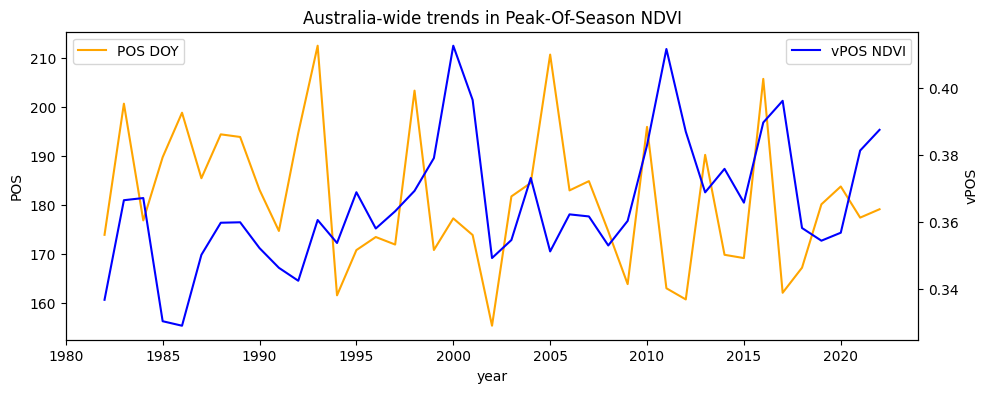

In [8]:
fig,ax=plt.subplots(1,1, figsize=(11,4))
ax2 = ax.twinx()
doy.POS.where(doy['POS']>20).mean(['x', 'y']).plot(ax=ax, c='orange', label='POS DOY')
doy.vPOS.where(doy['POS']>20).mean(['x', 'y']).plot(ax=ax2, c='blue', label='vPOS NDVI')
ax.legend(loc='upper left')
ax2.legend(loc='upper right')
ax.set_title('')
ax2.set_title('Australia-wide trends in Peak-Of-Season NDVI');

### Trends in POS/NDVI etc. disaggregrated by bioclimatic region

In [9]:
bio = assign_crs(xr.open_dataarray('/g/data/os22/chad_tmp/NEE_modelling/data/bioclimatic_regions.nc'), crs='EPSG:4326')
gdf = gpd.read_file('/g/data/os22/chad_tmp/NEE_modelling/data/bioclimatic_regions.geojson')

In [10]:
doy_var = [doy]
names = [var]

outer = []
for index, row in gdf.iterrows():
    mask = xr_rasterize(gdf.iloc[[index]], ds.isel(time=1))
    mask = round_coords(mask)
    
    if var=='NDVI':
        mask = mask.rename({'latitude':'y', 'longitude':'x'})
    
    inner = []
    for v,n in zip(doy_var, names):
        var_region = v.where(mask)
        
        doy_df = var_region.POS.mean(['x', 'y']).drop('spatial_ref').to_dataframe()
        doy_df['vPOS'] = var_region.vPOS.mean(['x', 'y']).drop('spatial_ref').to_dataframe()
        
        doy_df['region'] = row['region_name']
        doy_df = doy_df.rename({
            'vPOS':'vPOS ('+var+')',
            'POS':'Peak-Of-Season (DOY)'
                      },   
                      axis=1)
        inner.append(doy_df)
    outer.append(inner)

df=[]
for i in range(0,len(outer)):
    xx = df.append(pd.concat(outer[i]))
df = pd.concat(df)

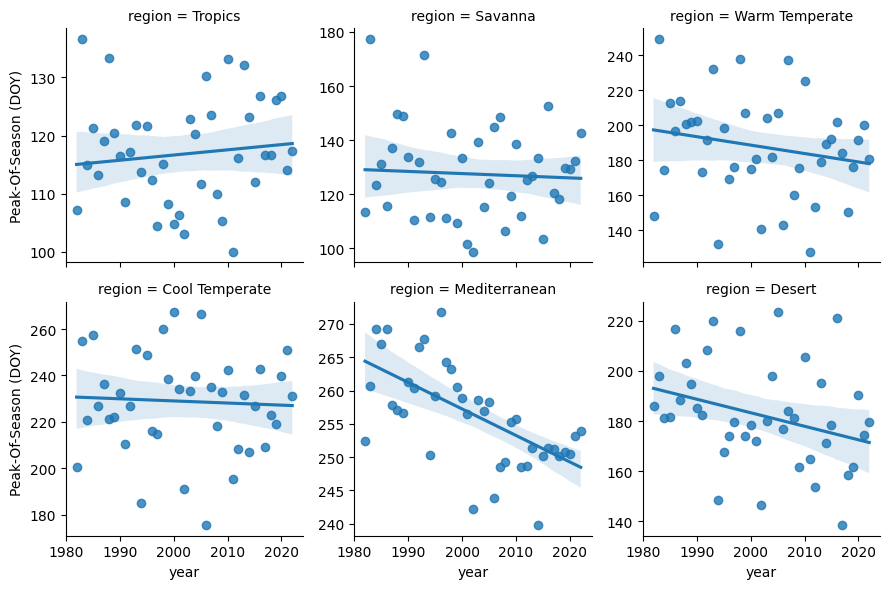

In [11]:
sb.lmplot(
    data=df.reset_index(), x="year", y="Peak-Of-Season (DOY)",
    col="region", height=3, robust=True, col_wrap=3,
    facet_kws=dict(sharex=True, sharey=False)
)

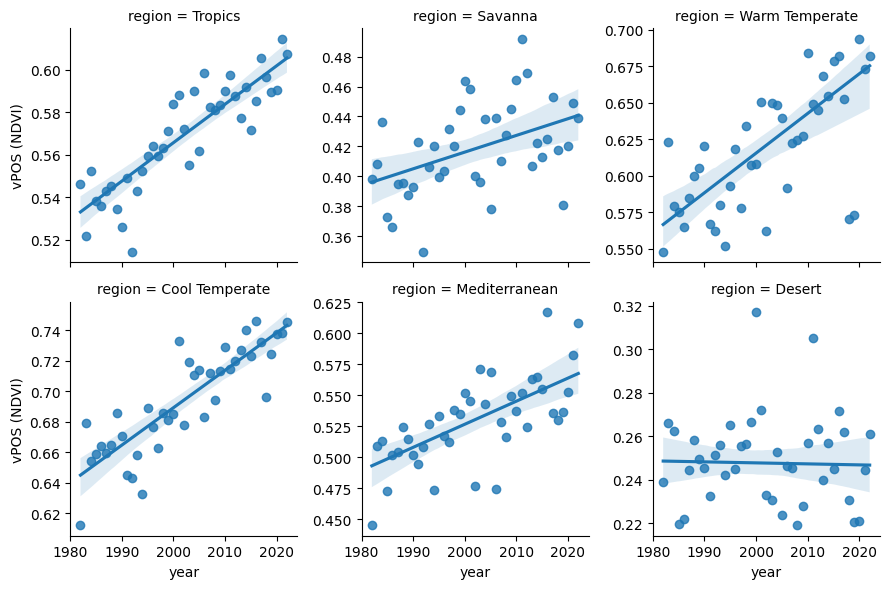

In [12]:
sb.lmplot(
    data=df.reset_index(), x="year", y="vPOS (NDVI)",
    col="region", height=3, robust=True, col_wrap=3,
    facet_kws=dict(sharex=True, sharey=False)
)

### Per pixel trends in POS

Use the Mann-Kendall robust regression (this is quite slow)

In [13]:
pos_trends = Mann_Kendall_test(doy['POS'].rename({'year':'time'}),
                               alpha=0.05,
                               method='theilslopes'
                              ).compute()
# pos_trends = linregress(doy['POS'].rename({'year':'time'}))

diff = doy['POS'].where(doy['POS']>20).sel(year=slice(2002, 2022)).median('year') - doy['POS'].where(doy['POS']>20).sel(year=slice(1982, 2001)).median('year')

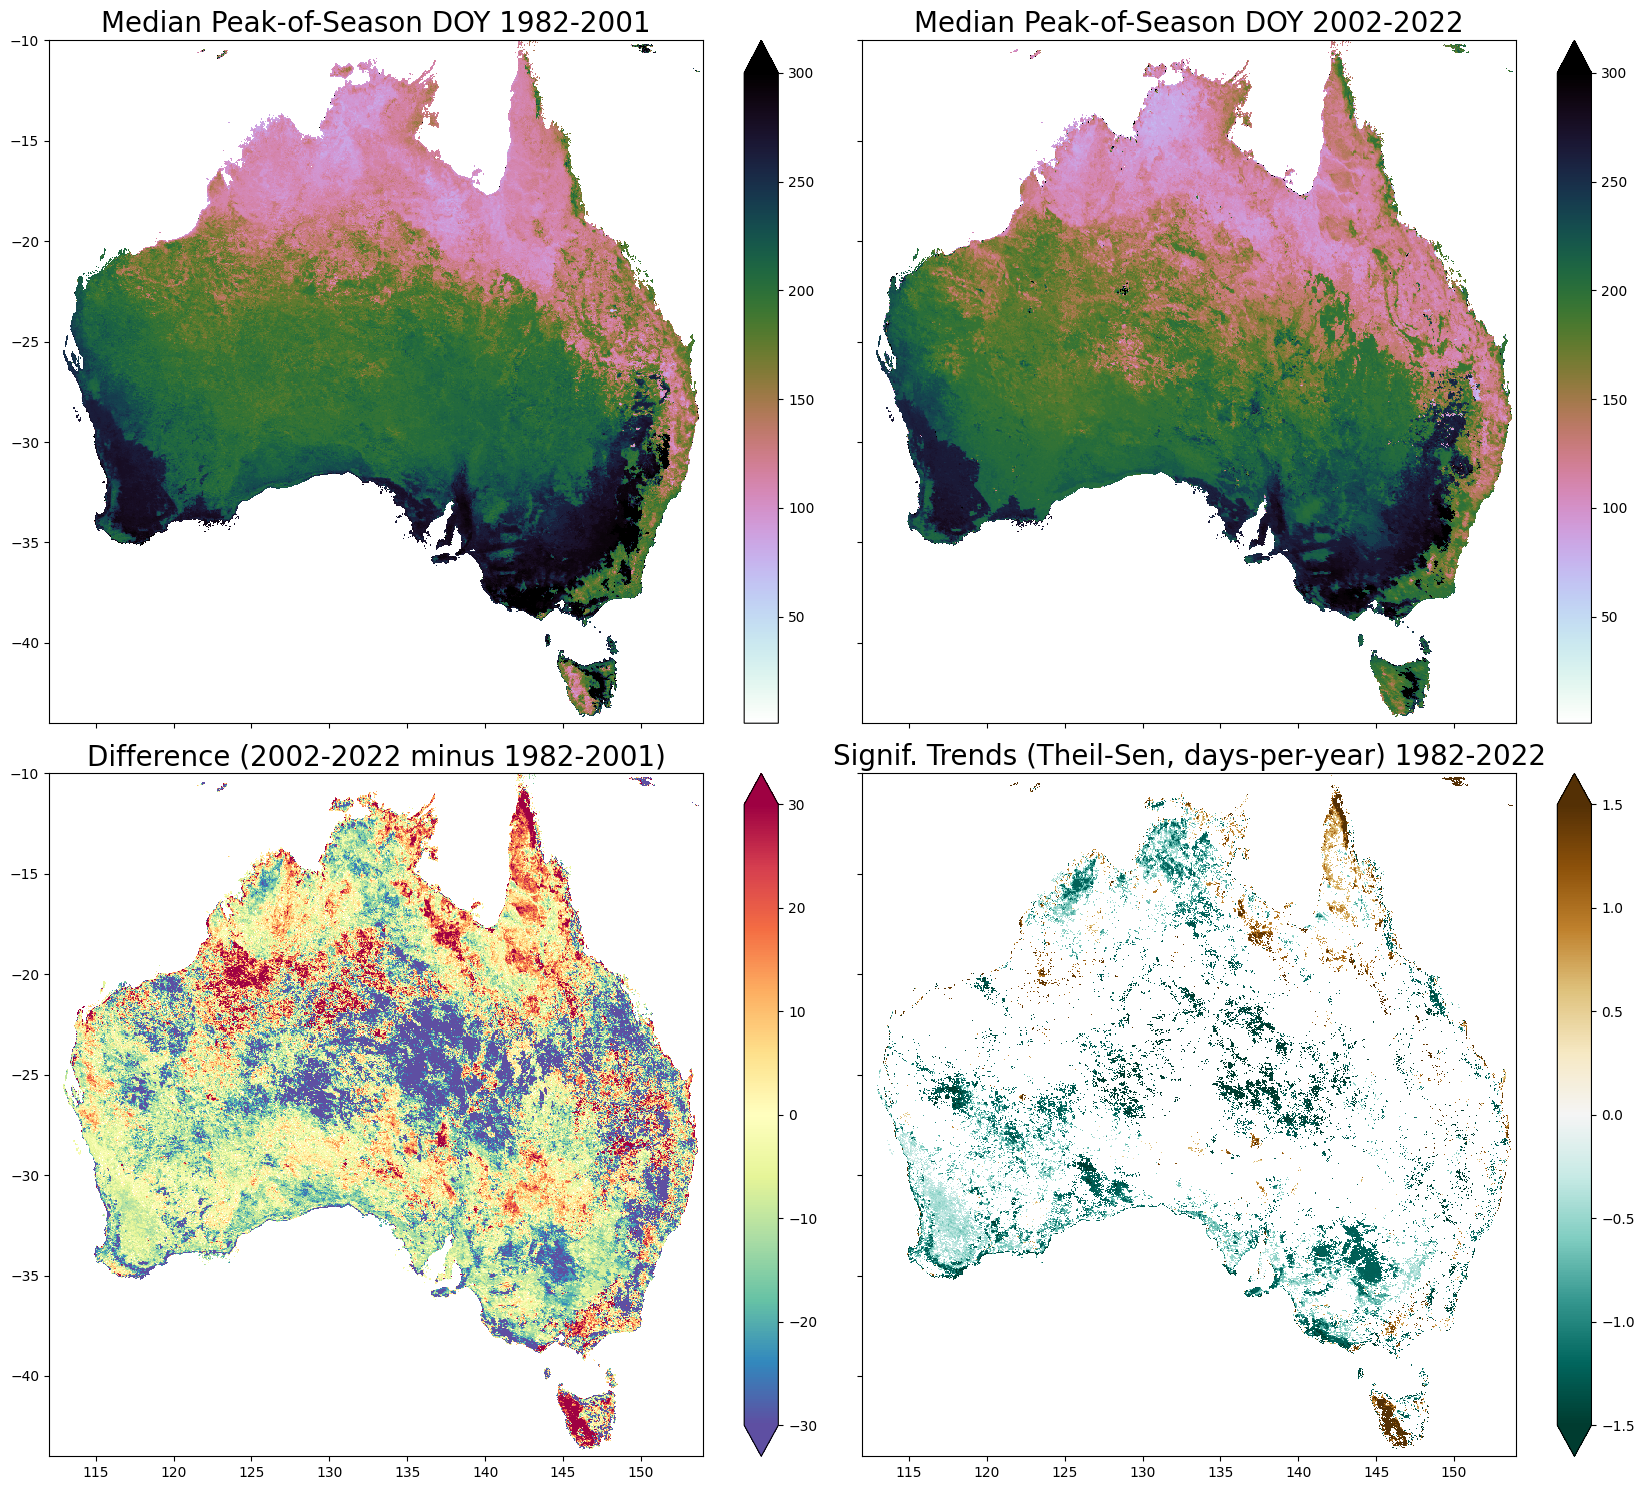

In [17]:
yrs = [(1982, 2001), (2002, 2022)]

vmin=1
vmax=300
font=20

fig,ax = plt.subplots(2,2, figsize=(17,15), sharex=True, sharey=True)
for a,i in zip(ax.reshape(-1), range(0,4)):

    if i==2:
        diff.where(diff!=0).plot(vmax=30, vmin=-30, ax=a, add_labels=False, cmap='Spectral_r')
        a.set_title('Difference (2002-2022 minus 1982-2001)', fontsize=font)

    elif i==3:
        pos_trends.trend.where(pos_trends.signif).plot(vmin=-1.5, vmax=1.5, ax=a, add_labels=False, cmap='BrBG_r')
        a.set_title('Signif. Trends (Theil-Sen, days-per-year) 1982-2022', fontsize=font)
    
    else:
        doy['POS'].where(doy['POS']>20).sel(year=slice(yrs[i][0], yrs[i][1])).median('year').plot.imshow(cmap='cubehelix_r', vmin=vmin, vmax=vmax, ax=a, add_labels=False)
        a.set_title('Median Peak-of-Season DOY '+str(yrs[i][0])+'-' +str(yrs[i][1]), fontsize=font)
        
plt.tight_layout()
fig.savefig("/g/data/os22/chad_tmp/climate-carbon-interactions/results/figs/POS_"+var+"_per_pixel_trends.png", bbox_inches='tight', dpi=300)


## Phenology curves

### Per bioregion

In [18]:
_var = [ds]
names = [var]

outer = []
for index, row in gdf.iterrows():
    mask = xr_rasterize(gdf.iloc[[index]], ds.isel(time=1))
    mask = round_coords(mask)
    if var=='NDVI':
        mask = mask.rename({'latitude':'y', 'longitude':'x'})
    
    inner = []
    for v,n in zip(_var, names):
        ds.name=var
        ds_region = v.where(mask)
        
        early_clim = ds_region.sel(time=slice('1982', '2001')).groupby('time.month').mean()
        late_clim = ds_region.sel(time=slice('2002', '2022')).groupby('time.month').mean()
        
        df = early_clim.mean(['x', 'y']).drop('spatial_ref').to_dataframe()
        df['2002-2022'] = late_clim.mean(['x', 'y']).drop('spatial_ref').to_dataframe()
        df = df.rename({'NDVI':'1982-2001'}, axis=1)
        
        df['region'] = row['region_name']
        # df['Month'] = ["J","F","M","A","M","J","J","A","S","O","N","D"]
        
        inner.append(df)
    outer.append(inner)

dffs=[]
for i in range(0,len(outer)):
    dffs.append(pd.concat(outer[i]))
df_ds_clim = pd.concat(dffs)

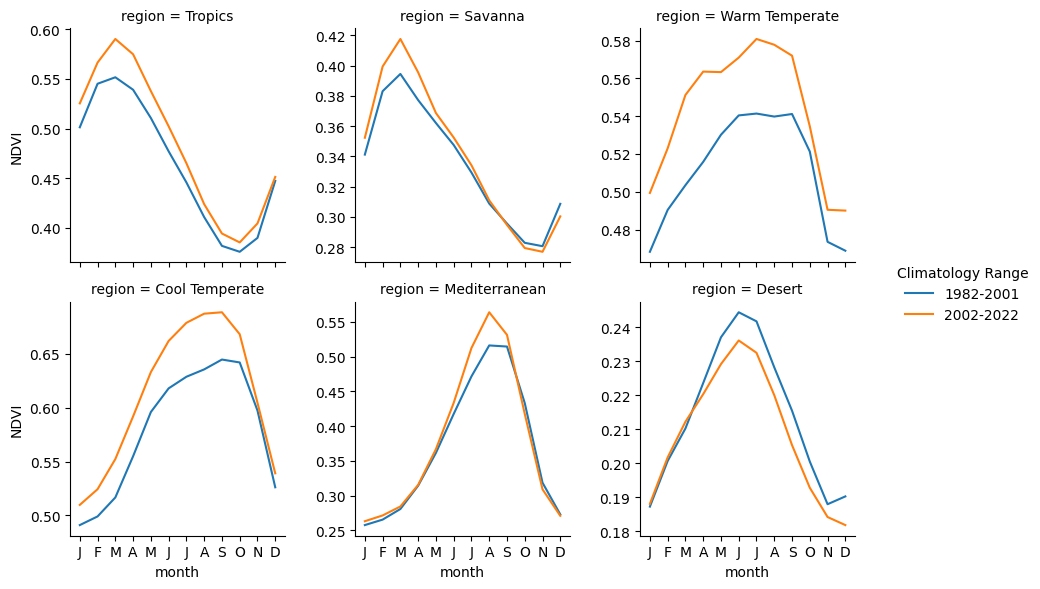

In [19]:
ax = sb.relplot(
    data=df_ds_clim.melt(id_vars='region', ignore_index=False, value_name=var, var_name='Climatology Range'),
    x="month",
    y=var,
    col="region",
    hue='Climatology Range',
    height=3, col_wrap=3, kind="line", ci=None,
    # palette=sb.color_palette("rocket_r"),
    facet_kws=dict(sharex=True, sharey=False)
)
ax.tight_layout();
ax.set(xticks=range(1,13))
ax.set_xticklabels(["J","F","M","A","M","J","J","A","S","O","N","D"], fontsize=10);

### Australian-wide

In [20]:
early_clim = ds.sel(time=slice('1982', '2001')).groupby('time.month').mean()
late_clim = ds.sel(time=slice('2002', '2022')).groupby('time.month').mean()

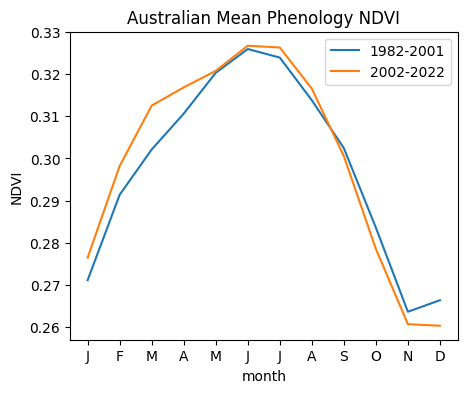

In [21]:
fig, ax = plt.subplots(1,1, figsize=(5,4))
early_clim.mean(['x','y']).plot(label='1982-2001', ax=ax)
late_clim.mean(['x','y']).plot(label='2002-2022', ax=ax)
ax.legend()
plt.title('Australian Mean Phenology '+var)
ax.set(xticks=range(1,13))
ax.set_xticklabels(["J","F","M","A","M","J","J","A","S","O","N","D"], fontsize=10);

## Check phenology changes over specific regions

Checking to see how much trends are due to inconsistiences between AVHRR and MODIS

In [22]:
#limit regions to tropics ~north of Twownsville
ds_tf = ds.sel(y=slice(0, -19.3))
ds_tf = ds_tf.sel(x=slice(142,147.5))

#tassie
# ds_tf = ds.sel(y=slice(-40, -45), x=slice(144,149))

# mid qld
# ds_tf = ds.sel(y=slice(-20, -25), x=slice(140,150))

#calculate minimum NDVI through the 20 years
tf_min = ds_tf.min('time')

#threshold minimum to get 
tf_mask = tf_min.where(tf_min>0.375)
tf_mask = xr.where(tf_mask>0, 1, 0)

In [28]:
early_clim_tf = ds_tf.where(tf_mask).sel(time=slice('1982', '2000')).groupby('time.month').mean()
late_clim_tf = ds_tf.where(tf_mask).sel(time=slice('2001', '2022')).groupby('time.month').mean()

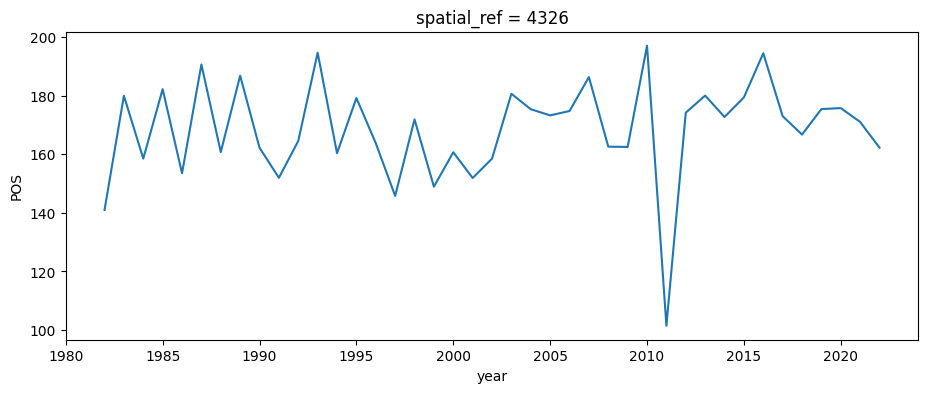

In [27]:
doy['POS'].where(tf_mask).mean(['x', 'y']).plot(figsize=(11,4))

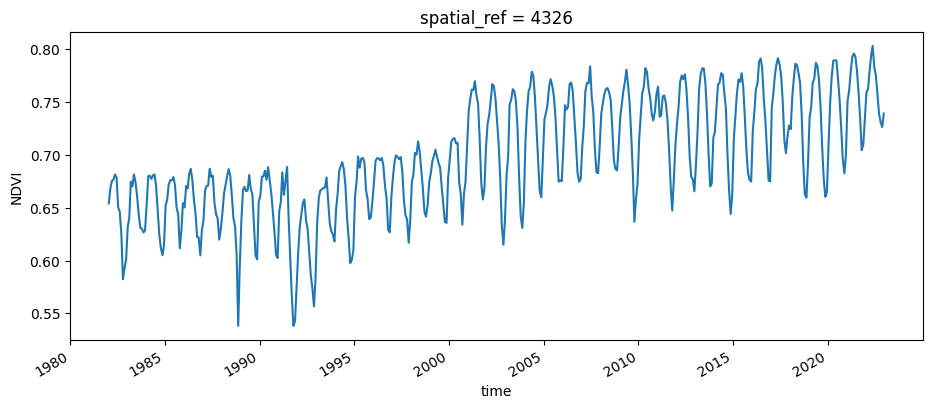

In [24]:
ds.where(tf_mask).mean(['x', 'y']).plot(figsize=(11,4))

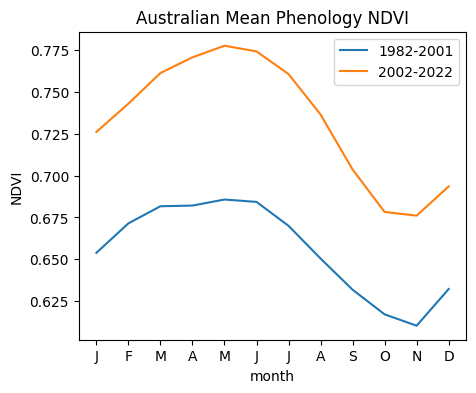

In [29]:
fig, ax = plt.subplots(1,1, figsize=(5,4))
early_clim_tf.mean(['x','y']).plot(label='1982-2001', ax=ax)
late_clim_tf.mean(['x','y']).plot(label='2002-2022', ax=ax)
ax.legend()
plt.title('Australian Mean Phenology '+var)
ax.set(xticks=range(1,13))
ax.set_xticklabels(["J","F","M","A","M","J","J","A","S","O","N","D"], fontsize=10);

## Contours

In [ ]:
# # List of elevations to extract
# z_values = [50, 100, 150, 200, 250, 300, 350]

# # Extract contours
# contours_gdf_early = subpixel_contours(da=doy['POS'].sel(year=slice(1982, 2001)).mean('year'), crs='epsg:4326', min_vertices=1000,
#                                  z_values=z_values)

# contours_gdf_late = subpixel_contours(da=doy['POS'].sel(year=slice(2001, 2022)).mean('year'), crs='epsg:4326', min_vertices=1000,
#                                  z_values=z_values)

# fig,ax = plt.subplots(1,1, figsize=(10,10), sharex=True, sharey=True)
# im = contours_gdf_early.plot(ax=ax, linewidth=1.0, cmap='magma', column ='z_value', legend=True, legend_kwds={'shrink': 0.5})
# ctx.add_basemap(ax, source=ctx.providers.Esri.WorldImagery, crs='EPSG:4326', attribution='Esri World Imagery', attribution_size=1)

# im = contours_gdf_late.plot(ax=ax, linewidth=1.0, cmap='viridis', column ='z_value', legend=True, legend_kwds={'shrink': 0.5})
# # ctx.add_basemap(ax[1], source=ctx.providers.Esri.WorldImagery, crs='EPSG:4326', attribution='Esri World Imagery', attribution_size=1)